In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2024-02-22 11:33:33.459823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 11:33:33.459859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 11:33:33.459884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 11:33:33.466562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 11:33:34.433641: W tensorflow/compiler/

2.14.0
CPU times: user 3.18 s, sys: 4.79 s, total: 7.98 s
Wall time: 2.75 s


In [2]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/MT-LIFT/train.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [8]:
%%time

sample = 1.0
random_state=20220720
df_criteo=df_criteo_ori[(df_criteo_ori['treatment'] == 0) | (df_criteo_ori['treatment'] == 3)].sample(frac=sample, random_state=random_state).reset_index(drop=True)
# Change 'treatment' from 3 to 1 in df_criteo_ori
df_criteo['treatment'] = df_criteo['treatment'].replace(3, 1)

# X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

# X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
# X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
# X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
# X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
# X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
# X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
# X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
# X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
# X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
# X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
# X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
# X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))
# # 
columns = [f'f{i}' for i in range(99) if not (80 <= i <= 82)] 
X = df_criteo[columns].values
# 
for i in range(X.shape[1]):
    # 
    if i not in [80, 81, 82]:
        X[:, i] = scaling(X[:, i], min=np.min(X[:, i]), max=np.max(X[:, i]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['click'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
# condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
# X_cali = X_cali[condition_cali]
# T_cali = T_cali[condition_cali]
# Y_visit_cali = Y_visit_cali[condition_cali]
# Y_conv_cali = Y_conv_cali[condition_cali]

# condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
# X_test = X_test[condition_test]
# T_test = T_test[condition_test]
# Y_visit_test = Y_visit_test[condition_test]
# Y_conv_test = Y_conv_test[condition_test]

# print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

2041521 (2041521, 96) (729116, 96) 2916459 (145822, 96)
CPU times: user 4.22 s, sys: 3.67 s, total: 7.89 s
Wall time: 7.9 s


In [4]:
count = 1

In [5]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve



# TPM-CF method:

### Train model and predict

/root/miniconda3/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/root/miniconda3/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_si

iteration =  1


[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:  1.2min
[Parallel(n_jobs=25)]: Done 256 out of 256 | elapsed:  1.9min finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:   32.7s
[Parallel(n_jobs=25)]: Done 256 out of 256 | elapsed:   55.4s finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    2.8s
[Parallel(n_jobs=25)]: Done 256 out of 256 | elapsed:    4.5s finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=25)]: Done 256 out of 256 | elapsed:    1.1s finished
[Parallel(n_jobs=25)]: Using backend ThreadingBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:  1.1

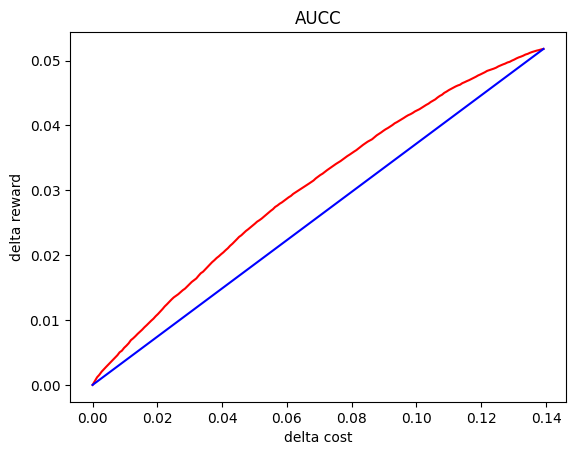

delta_cost  delta_reward  n_treatment  n_control  roi_pred_treatment  \
0      0.000000      0.000000            0          0            0.000000   
1      0.000697      0.000596         7148       6581            1.227865   
2      0.001392      0.001177        10453       9298            1.118793   
3      0.002089      0.001561        12185      10560            1.080681   
4      0.002786      0.002037        14537      12427            1.041295   
..          ...           ...          ...        ...                 ...   
196    0.136424      0.051442       381068     291105            0.429783   
197    0.137120      0.051547       383710     293375            0.427734   
198    0.137815      0.051627       387710     296897            0.424586   
199    0.138512      0.051731       397793     305823            0.416364   
200    0.139207      0.051807       411368     317748            0.404374   

     roi_pred_control  
0            0.000000  
1            1.257280  
2            1.148050  
3            1.112513  
4            1.071160  
..                ...  
196          0.433089  
197          0.430761  
198          0.427105  
199          0.417567  
200          0.403898  

[201 rows x 6 columns]

AUCC =  0.5841417308491434


In [6]:
import sklearn 
import sklearn.metrics
from metric.Metric import *
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
import pickle

grf_aucc_list = []

X_grf_train = X_train
T_grf_train = T_train.flatten()
Y_visit_grf_train = Y_visit_train.flatten()
Y_conv_grf_train = Y_conv_train.flatten()

X_grf_test = X_test
T_grf_test = T_test.flatten()
Y_visit_grf_test = Y_visit_test.flatten()
Y_conv_grf_test = Y_conv_test.flatten()

for i in range(count):
    
    print("iteration = ", i + 1)
    
    depth = 6
    min_samples_leaf = 1000
    n_estimators = 256

    grf_random_state = 20220723 + i * 11
    
    # visit
    est_it = CausalForestDML(model_y=RandomForestClassifier(n_estimators=150, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=150, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=25,
                          max_depth=depth,
                          verbose=1,
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Y_visit_grf_train, T_grf_train, X=X_grf_train, cache_values=True)
    
    model_file = "../model_file/uplift/criteo/final_model/grf/A_visit_CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    grf_test_pre_visit = est_it.effect(X_grf_test)
    
    # conv
    est_it = CausalForestDML(model_y=RandomForestClassifier(n_estimators=50, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=50, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=25,
                          max_depth=depth,
                          verbose=1,   
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Y_conv_grf_train, T_grf_train, X=X_grf_train, cache_values=True)
    
    model_file = "../model_file/uplift/criteo/final_model/grf/A_conv_CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    grf_test_pre_conv = est_it.effect(X_grf_test)
    
    # roi
    
    roi_grf_pre = grf_test_pre_conv / np.where(abs(grf_test_pre_visit) < 1e-6, 1e-6, grf_test_pre_visit)


    grf_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_grf_pre.flatten(), quantile=200)

    grf_aucc_list.append(grf_aucc)

In [7]:
A_grf_aucc_list = get_aucc_cost_curve(grf_aucc_list)
print("aucc = ", np.sum(A_grf_aucc_list['delta_reward'].values) / (A_grf_aucc_list['delta_reward'].values[-1] * 201))
A_grf_aucc_list.to_csv("../figure/mt/A_grf_aucc_list.csv")

aucc =  0.5841417308491434
